## 데이터 모음

In [1]:
import torch

print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능 여부: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
    print(f"GPU 개수: {torch.cuda.device_count()}")
    print(f"현재 사용 중인 디바이스 번호: {torch.cuda.current_device()}")
else:
    print("CUDA를 사용할 수 없습니다.")

PyTorch 버전: 2.5.1+cu124
CUDA 사용 가능 여부: True
CUDA 버전: 12.4
GPU 이름: NVIDIA RTX A6000
GPU 개수: 2
현재 사용 중인 디바이스 번호: 0


In [3]:
import os
import pandas as pd

data_path = "/home/hknu/mnt/kjh/sorted_faces_a" # 데이터 경로 작성하면 됨.
paths= []
labels = []
datasets = []
#ㅁ
for path, _, filenames in os.walk(data_path):
    for filename in filenames:
        if '.jpg' in filename:
            file_path = path + '/' + filename
            paths.append(file_path)

            if '/drowsy' in file_path:
                labels.append("drowsy")
            elif '/focused' in file_path:
                labels.append('focused')
            elif '/not_focused' in file_path:
                labels.append('not_focused')
            else:
                labels.append('N/A')

            if '/train' in file_path:
                datasets.append('train')
            elif '/validation' in file_path:
                datasets.append('validation')

data_df = pd.DataFrame({"path":paths, "label":labels, "dataset":datasets})
label_mapping = {"focused":0, "not_focused":1, "drowsy":2}

data_df["target"] = data_df["label"].map(label_mapping)
data_df.head()


,path,label,dataset,target


In [4]:
# 데이터 개수 확인
focus_count = data_df[data_df["label"]=="focused"]["label"].count()
not_focus_count = data_df[data_df["label"]=="not_focused"]["label"].count()
drowsy_count = data_df[data_df["label"]=="drowsy"]["label"].count()
total_count = data_df["label"].count() if (focus_count + not_focus_count + drowsy_count) == data_df["label"].count() else "error"

# 개수가 맞으면 total이 총합으로 나올 것이고, error가 출력된다면 결측값이 있다는 것이다.
print(f"Focused: {focus_count}\nNot Focused: {not_focus_count}\nDrowsy: {drowsy_count}\n\nTotal: {total_count}")

Focused: 0
Not Focused: 0
Drowsy: 0

Total: 0


In [8]:
import json

json_path = "/home/hknu/Zypt_Model/landmarks.json"

with open(json_path, 'r') as f:
    data = json.load(f)

image_count = len(data)  # 각 항목이 하나의 이미지에 해당

# 리스트 → 데이터프레임
landmark_df = pd.DataFrame(data)

print(f"총 이미지 개수: {image_count}")
landmark_df.head()

총 이미지 개수: 519476


,landmarks,path
0,"[[567, 317], [568, 294], [568, 301], [562, 268...",/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...
1,"[[556, 354], [557, 324], [557, 332], [553, 295...",/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...
2,"[[567, 318], [568, 295], [568, 302], [562, 269...",/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...
3,"[[554, 353], [556, 323], [556, 331], [552, 295...",/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...
4,"[[568, 310], [568, 284], [568, 293], [562, 259...",/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...


In [9]:
merged_df = pd.merge(data_df, landmark_df, on="path", how="left")
merged_df = merged_df.dropna(subset=['landmarks'])
merged_df.head()

,path,label,dataset,target,landmarks
0,/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...,focused,train,0,"[[567, 317], [568, 294], [568, 301], [562, 268..."
1,/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...,focused,train,0,"[[556, 354], [557, 324], [557, 332], [553, 295..."
2,/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...,focused,train,0,"[[567, 318], [568, 295], [568, 302], [562, 269..."
3,/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...,focused,train,0,"[[554, 353], [556, 323], [556, 331], [552, 295..."
4,/home/hknu/mnt/kjh/sorted_faces_a/train/focuse...,focused,train,0,"[[568, 310], [568, 284], [568, 293], [562, 259..."


In [10]:
from sklearn.model_selection import train_test_split

tr_df = merged_df[merged_df["dataset"]=="train"]
validation_df = merged_df[merged_df["dataset"]=="validation"]
val_df, test_df = train_test_split(validation_df, test_size=0.3, stratify=validation_df["target"], random_state=2025)

tr_df.shape, val_df.shape, test_df.shape

((379709, 5), (97836, 5), (41931, 5))

## DataLoader

In [11]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class FocusDataset(Dataset):
    def __init__(self, image_paths, targets=None, landmarks=None, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.landmarks = landmarks
        self.transform = transform

        # 이미지 크기 (상수로 설정)
        self.IMG_WIDTH = 1080
        self.IMG_HEIGHT = 720

    def __len__(self):
        return len(self.image_paths)

    def normalize_landmarks(self, landmarks):
        landmarks = np.array(landmarks, dtype=np.float32)
        landmarks[:, 0] /= self.IMG_WIDTH
        landmarks[:, 1] /= self.IMG_HEIGHT
        return landmarks

    def __getitem__(self, idx):
        # 랜드마크 정규화 및 텐서 변환
        landmark = None
        if self.landmarks is not None:
            landmark = self.normalize_landmarks(self.landmarks.iloc[idx])
            landmark = torch.tensor(landmark, dtype=torch.float32)  # (468, 2)

        if self.targets is not None:
            target = torch.tensor(self.targets[idx])
            return landmark, target

        return landmark


In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

IMG_SIZE = 224
IMG_MEANS = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 256

# tr_transform = A.Compose([
#     A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.7, 1.0), ratio=(0.8, 1.2)),
#     A.HorizontalFlip(p=0.5),
#     A.ColorJitter(0.3, 0.3, 0.3, 0.1),
#     A.MotionBlur(p=0.2),
#     A.GaussNoise(p=0.3),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Normalize(),
#     ToTensorV2()
# ])

tr_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Affine(translate_percent=0.0625, scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.CLAHE(p=0.1),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

# tr_transform = A.Compose([
#     A.Resize(IMG_SIZE, IMG_SIZE),
#     A.HorizontalFlip(p=0.5),
#     A.Normalize(mean=IMG_MEANS, std=IMG_STD),
#     ToTensorV2()
# ])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=IMG_MEANS, std=IMG_STD),
    ToTensorV2()
])

def create_tr_val_loader(tr_df, val_df, tr_transform, val_transform):
    tr_dataset = FocusDataset(image_paths=tr_df["path"].to_list(), targets=tr_df["target"].to_list(),
                              landmarks=tr_df["landmarks"], transform=tr_transform)
    tr_loader = DataLoader(tr_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    if val_df is not None:
        val_dataset = FocusDataset(image_paths=val_df["path"].to_list(), targets=val_df["target"].to_list(), 
                                   landmarks=val_df["landmarks"], transform=val_transform)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

        return tr_loader, val_loader
    
    return tr_loader, None

tr_loader, val_loader = create_tr_val_loader(tr_df, val_df, tr_transform, val_transform)


/home/hknu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
landmarks, targets = next(iter(tr_loader))
print(landmarks.shape, targets.shape)

torch.Size([256, 468, 2]) torch.Size([256])


## Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale


class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.act1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock(out_channels)

        self.downsample = downsample
        if downsample or in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.residual = nn.Identity()

        self.act2 = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.residual(x)
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.se(self.bn2(self.conv2(out)))
        out += identity
        return self.act2(out)


class Conv1DLandmarkEncoder(nn.Module):
    def __init__(self, in_channels=2, out_dim=128, num_classes=3):
        super().__init__()
        self.encoder = nn.Sequential(
            ResidualBlock1D(in_channels, 32, downsample=True),
            ResidualBlock1D(32, 64, downsample=True),
            ResidualBlock1D(64, 128, downsample=True),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.Hardswish(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x): 
        x = x.permute(0, 2, 1) 
        x = self.encoder(x)
        return self.classifier(x)


In [15]:
model = Conv1DLandmarkEncoder()

## Tr~~~

In [16]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

class Trainer:
    def __init__(self, model, loss_fn, optimizer, tr_loader, val_loader, scheduler=None, callbacks=None, metric=None, device=None):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.tr_loader = tr_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.callbacks = callbacks
        self.metric = metric.to(device)
        self.device = device
        self.current_lr = self.optimizer.param_groups[0]['lr']
    
    def train_epoch(self, epoch):
        self.model.train()

        accu_loss = 0.0

        self.metric.reset()
        with tqdm(total=len(self.tr_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.tr_loader):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                accu_loss += loss.item()
                running_avg_loss = accu_loss / (batch_idx + 1)

                pred_proba = F.softmax(outputs, dim=-1)
                self.metric.update(pred_proba, targets)

                progress_bar.update(1)
                if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                    progress_bar.set_postfix({"Loss": running_avg_loss,
                                              "Metric": self.metric.compute().item()})  # 수정됨 (Metrix → Metric)


        if self.scheduler is not None and not(isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)):
            self.scheduler.step()
            self.current_lr = self.scheduler.get_last_lr()[0]
        
        return running_avg_loss, self.metric.compute().item()
    
    def valid_epoch(self, epoch):
        if self.val_loader is None:
            return None, None
        
        self.model.eval()
        accu_loss = 0.0

        self.metric.reset()
        with torch.no_grad():  # 수정됨
            with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validation]", leave=True) as progress_bar:
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    outputs = self.model(inputs)

                    loss = self.loss_fn(outputs, targets)
                    accu_loss += loss.item()
                    running_avg_loss = accu_loss / (batch_idx + 1)

                    pred_proba = F.softmax(outputs, dim=-1)  # 수정됨: dim=-1 명시
                    self.metric.update(pred_proba, targets)

                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Loss": running_avg_loss, 
                                                  "Metric": self.metric.compute().item()})  # 수정됨 (Metrix → Metric)

        if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step(running_avg_loss)
            self.current_lr = self.scheduler.get_last_lr()[0]

        return running_avg_loss, self.metric.compute().item()
    
    def fit(self, epochs):
        history = {"train_loss" : [], "train_metric" : [], "val_loss" : [], "val_metric" : [], "lr" : []}
        for epoch in range(epochs):
            train_loss, train_metric = self.train_epoch(epoch)
            val_loss, val_metric = self.valid_epoch(epoch)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f} Train Metric: {train_metric:.4f}",
                  f", Val Loss: {val_loss:.4f} Val Metric: {val_metric:.4f}" if val_loss is not None else "",
                  f", Current lr: {self.current_lr:.6f}")
            history["train_loss"].append(train_loss); history["train_metric"].append(train_metric)
            history["val_loss"].append(val_loss); history["val_metric"].append(val_metric)
            history["lr"].append(self.current_lr)
        
            if self.callbacks:
                is_epoch_loop_break = self._execute_callbacks(self.callbacks, self.model, epoch, val_loss, val_metric)
                if is_epoch_loop_break:
                    break

        return history
    
    def _execute_callbacks(self, callbacks, model, epoch, val_loss, val_metric):
        is_epoch_loop_break = False

        for callback in self.callbacks:
            if isinstance(callback, ModelCheckpoint):
                if callback.monitor == 'val_loss':
                    callback.save(model, epoch, val_loss)
                elif callback.monitor == 'val_metric':
                    callback.save(model, epoch, val_metric)

            if isinstance(callback, EarlyStopping):
                if callback.monitor == 'val_loss':
                    is_epoch_loop_break = callback.check_early_stop(val_loss)
                elif callback.monitor == 'val_metric':
                    is_epoch_loop_break = callback.check_early_stop(val_metric)

        return is_epoch_loop_break
    
    def get_trained_model(self):
        return self.model


In [17]:
class Predictor:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device

    def evaluate(self, loader):
        # 현재 입력으로 들어온 데이터의 batch 통계(mean, variance)를 사용하지 않고, 학습 시 계산된 running 통계값을 사용
        self.model.eval()
        eval_metric = 0.0
        # 정확도 계산을 위한 전체 건수 및 누적 정확건수
        num_total = 0.0
        accu_num_correct = 0.0

        with tqdm(total=len(loader), desc=f"[Evaluating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    pred = self.model(inputs)

                    # 정확도 계산을 위해 누적 전체 건수와 누적 전체 num_correct 건수 계산  
                    num_correct = (pred.argmax(-1) == targets).sum().item()
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    eval_metric = accu_num_correct / num_total

                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Accuracy": eval_metric})
        
        return eval_metric

    def predict_proba(self, inputs):
        self.model.eval()
        with torch.no_grad():
            inputs = inputs.to(self.device)
            outputs = self.model(inputs)
            #예측값을 반환하므로 targets은 필요 없음.
            #targets = targets.to(self.device)
            pred_proba = F.softmax(outputs, dim=-1) #또는 dim=1

        return pred_proba

    def predict(self, inputs):
        pred_proba = self.predict_proba(inputs)
        pred_class = torch.argmax(pred_proba, dim=-1)

        return pred_class

In [18]:
import os
import torch

class ModelCheckpoint:
    def __init__(self, checkpoint_dir='checkpoints', monitor='val_loss', mode='min', save_interval=1, verbose=1):
        self.checkpoint_dir = checkpoint_dir
        self.monitor = monitor
        self.mode = mode
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.verbose = verbose
        self.save_interval = save_interval
        self._make_checkpoint_dir_unless()

    def _make_checkpoint_dir_unless(self):
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
    
    # mode 유형에 따라 metric value값이 이전 epoch시 보다 향상 되었는지 확인하여 True/False 값 return
    def is_improvement(self, value):
        if self.mode == 'min':
            return value < self.best_value
        else:
            return value > self.best_value

    # self.best_value값 update, is_improvement() 반환값이 True인 경우만 수행. 
    def update_best_value(self, value):
        self.best_value = value

    def save(self, model, epoch, value):
        if self.save_interval == 1:
            if self.is_improvement(value):
                self._checkpoint_save(model, epoch, value)
                self.update_best_value(value)
            
        elif self.save_interval > 1:
            if (epoch + 1) % self.save_interval == 0:
                self._checkpoint_save(model, epoch, value)
            
    def _checkpoint_save(self, model, epoch, value):
        checkpoint_path = os.path.join(self.checkpoint_dir, 
                                       f'checkpoint_epoch_{epoch+1}_{self.monitor}_{value:.4f}.pt')
        torch.save(model.state_dict(), checkpoint_path)
        if self.verbose:
            print(f"Saved model checkpoint at {checkpoint_path}")

In [19]:
class EarlyStopping:
    def __init__(self, monitor='val_loss', mode='min', early_patience=5, verbose=1):
        self.monitor = monitor
        self.mode = mode
        self.early_patience = early_patience
        self.verbose = verbose
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.counter = 0

    def is_improvement(self, value):
        if self.mode == 'min':
            return value < self.best_value
        else:
            return value > self.best_value

    def check_early_stop(self, value):
        is_early_stopped = False
        
        if self.is_improvement(value):
            self.best_value = value
            self.counter = 0
            is_early_stopped =False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.early_patience}")
            if self.counter >= self.early_patience:
                is_early_stopped = True
                if self.verbose:
                    print("Early stopping happens and train stops")
        
        return is_early_stopped
        

## Training

In [20]:
import torch.optim as optim
from torch.optim import Adam, AdamW

def train_focus(model, tr_df, val_df, tr_transform, val_transform, 
                metric=None, learning_rate=1e-3, lr_scheduler_fn=None, 
                callbacks=None, epochs=30):
    tr_loader, val_loader = create_tr_val_loader(tr_df=tr_df, val_df=val_df, 
                                                 tr_transform=tr_transform, val_transform=val_transform)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    scheduler = lr_scheduler_fn(optimizer)

    trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer, 
                      tr_loader=tr_loader, val_loader=val_loader, scheduler=scheduler, callbacks=callbacks,
                      metric=metric, device=device)
    history = trainer.fit(epochs)

    return trainer, history

In [21]:
from torchmetrics.classification import AUROC, Accuracy, F1Score

acu_metric = Accuracy(task='multiclass', num_classes=3)
f1_score = F1Score(task='multiclass', num_classes=3, average='macro')

def get_reduce_lr_scheduler(optimizer):
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.2, patience=2, threshold=0.01, min_lr=1e-6)
    
    return lr_scheduler

def get_cosine_annealing_lr(optimizer):
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=10, eta_min=1e-5)

    return scheduler

model_checkpoint = ModelCheckpoint('/home/hknu/Zypt_Model/landmark_model', monitor='val_metric', mode='max') # 체크포인트 위치 변경.
early_stopping = EarlyStopping(monitor='val_metric', mode='max', early_patience=5, verbose=1)
trainer_mobilenetv3_s_100, history = train_focus(model, tr_df=tr_df, val_df=val_df,
                                  tr_transform=tr_transform, val_transform=val_transform,
                                  metric=acu_metric, learning_rate=1e-3, 
                                  lr_scheduler_fn=get_cosine_annealing_lr, callbacks=[model_checkpoint, early_stopping], 
                                  epochs=30)


Epoch 1 [Validation]: 100%|██████████| 383/383 [00:21<00:00, 18.20it/s, Loss=0.707, Metric=0.833]


Epoch 1/30, Train Loss: 0.5856 Train Metric: 0.8345 , Val Loss: 0.7069 Val Metric: 0.8328 , Current lr: 0.000976
Saved model checkpoint at /home/hknu/Zypt_Model/landmark_model/checkpoint_epoch_1_val_metric_0.8328.pt


Epoch 2 [Validation]: 100%|██████████| 383/383 [00:21<00:00, 17.97it/s, Loss=0.451, Metric=0.921]


Epoch 2/30, Train Loss: 0.4074 Train Metric: 0.9452 , Val Loss: 0.4506 Val Metric: 0.9214 , Current lr: 0.000905
Saved model checkpoint at /home/hknu/Zypt_Model/landmark_model/checkpoint_epoch_2_val_metric_0.9214.pt


Epoch 3 [Validation]: 100%|██████████| 383/383 [00:20<00:00, 18.66it/s, Loss=0.516, Metric=0.88] 


Epoch 3/30, Train Loss: 0.3801 Train Metric: 0.9583 , Val Loss: 0.5160 Val Metric: 0.8798 , Current lr: 0.000796
EarlyStopping counter: 1/5


Epoch 4 [Validation]: 100%|██████████| 383/383 [00:22<00:00, 16.99it/s, Loss=0.545, Metric=0.876]


Epoch 4/30, Train Loss: 0.3718 Train Metric: 0.9625 , Val Loss: 0.5447 Val Metric: 0.8763 , Current lr: 0.000658
EarlyStopping counter: 2/5


Epoch 5 [Validation]: 100%|██████████| 383/383 [00:22<00:00, 16.79it/s, Loss=0.939, Metric=0.687]


Epoch 5/30, Train Loss: 0.3642 Train Metric: 0.9668 , Val Loss: 0.9394 Val Metric: 0.6866 , Current lr: 0.000505
EarlyStopping counter: 3/5


Epoch 6 [Validation]: 100%|██████████| 383/383 [00:20<00:00, 18.37it/s, Loss=0.467, Metric=0.906]


Epoch 6/30, Train Loss: 0.3591 Train Metric: 0.9693 , Val Loss: 0.4673 Val Metric: 0.9059 , Current lr: 0.000352
EarlyStopping counter: 4/5


Epoch 7 [Validation]: 100%|██████████| 383/383 [00:21<00:00, 18.04it/s, Loss=0.411, Metric=0.936]


Epoch 7/30, Train Loss: 0.3537 Train Metric: 0.9726 , Val Loss: 0.4110 Val Metric: 0.9362 , Current lr: 0.000214
Saved model checkpoint at /home/hknu/Zypt_Model/landmark_model/checkpoint_epoch_7_val_metric_0.9362.pt


Epoch 8 [Validation]: 100%|██████████| 383/383 [00:20<00:00, 18.35it/s, Loss=0.436, Metric=0.925]


Epoch 8/30, Train Loss: 0.3487 Train Metric: 0.9750 , Val Loss: 0.4360 Val Metric: 0.9252 , Current lr: 0.000105
EarlyStopping counter: 1/5


Epoch 9 [Validation]: 100%|██████████| 383/383 [00:21<00:00, 17.53it/s, Loss=0.402, Metric=0.942]


Epoch 9/30, Train Loss: 0.3446 Train Metric: 0.9775 , Val Loss: 0.4020 Val Metric: 0.9422 , Current lr: 0.000034
Saved model checkpoint at /home/hknu/Zypt_Model/landmark_model/checkpoint_epoch_9_val_metric_0.9422.pt


Epoch 10 [Validation]: 100%|██████████| 383/383 [00:21<00:00, 17.75it/s, Loss=0.405, Metric=0.941]


Epoch 10/30, Train Loss: 0.3418 Train Metric: 0.9789 , Val Loss: 0.4047 Val Metric: 0.9410 , Current lr: 0.000010
EarlyStopping counter: 1/5


Epoch 11 [Validation]: 100%|██████████| 383/383 [00:22<00:00, 16.75it/s, Loss=0.41, Metric=0.939] 


Epoch 11/30, Train Loss: 0.3406 Train Metric: 0.9797 , Val Loss: 0.4098 Val Metric: 0.9387 , Current lr: 0.000034
EarlyStopping counter: 2/5


Epoch 12 [Validation]: 100%|██████████| 383/383 [00:21<00:00, 17.81it/s, Loss=0.421, Metric=0.934]


Epoch 12/30, Train Loss: 0.3409 Train Metric: 0.9795 , Val Loss: 0.4210 Val Metric: 0.9337 , Current lr: 0.000105
EarlyStopping counter: 3/5


Epoch 13 [Validation]: 100%|██████████| 383/383 [00:21<00:00, 17.57it/s, Loss=0.404, Metric=0.941]


Epoch 13/30, Train Loss: 0.3427 Train Metric: 0.9785 , Val Loss: 0.4040 Val Metric: 0.9411 , Current lr: 0.000214
EarlyStopping counter: 4/5


Epoch 14 [Validation]: 100%|██████████| 383/383 [00:22<00:00, 17.18it/s, Loss=0.412, Metric=0.938]

Epoch 14/30, Train Loss: 0.3448 Train Metric: 0.9774 , Val Loss: 0.4121 Val Metric: 0.9380 , Current lr: 0.000352
EarlyStopping counter: 5/5
Early stopping happens and train stops


## 평가

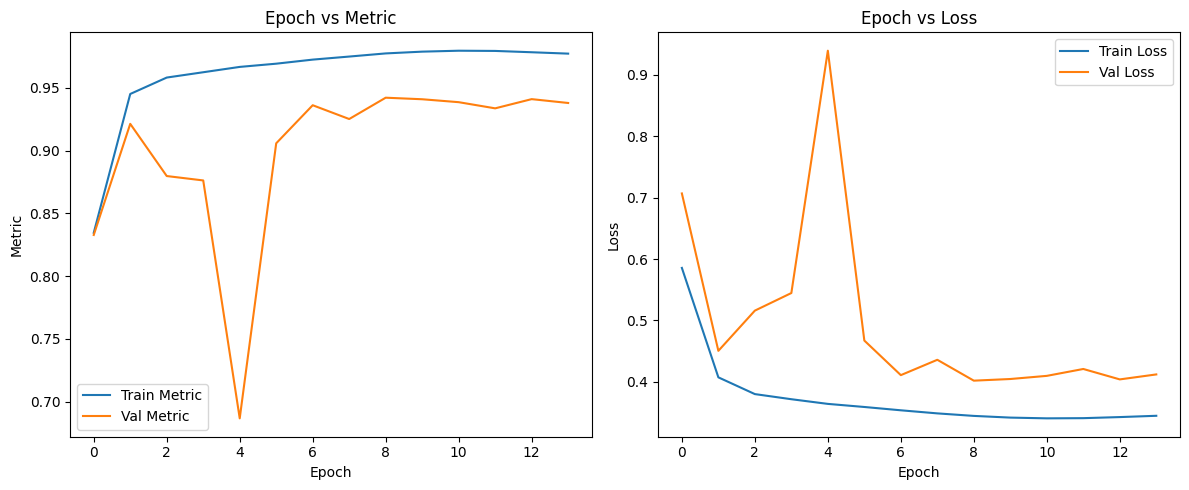

In [22]:
import matplotlib.pyplot as plt

# Metric 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_metric'], label='Train Metric')
plt.plot(history['val_metric'], label='Val Metric')
plt.title('Epoch vs Metric')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [26]:
# 가장 검증 성능이 좋은 weight 파일을 모델로 로딩. 
state_dict = torch.load('/home/hknu/Zypt_Model/landmark_model/checkpoint_epoch_9_val_metric_0.9422.pt', weights_only=True)
best_trained_model = Conv1DLandmarkEncoder()
best_trained_model.load_state_dict(state_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predictor = Predictor(best_trained_model, device)

test_dataset = FocusDataset(image_paths=test_df["path"].to_list(), targets=test_df["target"].to_list(),
                          landmarks=test_df["landmarks"], transform=tr_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

predictor.evaluate(test_loader)

[Evaluating]: 100%|██████████| 164/164 [00:11<00:00, 14.64it/s, Accuracy=0.942]


0.9415945243376023